In [1]:
import os
import cv2
import warnings
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
from tensorflow.math import reduce_std
from tensorflow import reduce_mean, square, clip_by_value
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

c:\Users\yosef\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
x_train_gray = np.load("x_train_grayOP.npy")
x_train_color = np.load("x_train_colorOP.npy")
x_test_gray = np.load("x_test_grayOP.npy")
x_test_color = np.load("x_test_colorOP.npy")

In [2]:
x_train_gray = np.load("x_train_grayN2.npy")
x_train_color = np.load("x_train_colorN2.npy")
x_test_gray = np.load("x_test_grayN2.npy")
x_test_color = np.load("x_test_colorN2.npy")

U-NET 1

In [ ]:
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Bottleneck
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Decoder
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    
    # Output layer (3 channels for RGB)
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build the model
input_shape = (256, 256, 1)  # Grayscale manga image shape
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='mse')
model.summary()

U-NET 2

In [7]:
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x
    
    # Encoder blocks
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    # Bottleneck
    conv3 = conv_block(pool2, 256)
    
    # Decoder
    up1 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(conv3)
    concat1 = layers.concatenate([up1, conv2])
    conv4 = conv_block(concat1, 128)
    
    up2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(conv4)
    concat2 = layers.concatenate([up2, conv1])
    conv5 = conv_block(concat2, 64)
    
    # Output (ab channels)
    outputs = layers.Conv2D(2, (3, 3), activation='tanh', padding='same')(conv5)
    
    # Add clipping via Lambda layer
    outputs = layers.Lambda(
        lambda x: clip_by_value(x, -1.0 + 1e-8, 1.0 - 1e-8)  # Strict [-1, 1]
    )(outputs)
    
    return models.Model(inputs, outputs)

In [8]:
def color_loss(y_true, y_pred):
    mse = reduce_mean(square(y_true - y_pred))
    
    pred_std = reduce_std(y_pred, axis=[1, 2])
    color_term = -reduce_mean(pred_std)  # Encourage higher std
    
    # Penalize extreme ab values (adjust lambda as needed)
    ab_penalty = 0.01 * reduce_mean(square(y_pred))  # Keep ab near 0
    
    return mse + 0.3 * color_term + ab_penalty  # Reduced color term weight

In [9]:
class ColorizationDataGenerator(Sequence):
    def __init__(self, gray_images, rgb_images, batch_size=8, augment=True):
        self.gray_images = gray_images  # (n, 256, 256, 1)
        self.rgb_images = rgb_images    # (n, 256, 256, 3)
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.gray_images) / self.batch_size))

    @property
    def num_batches(self):
        # Required to resolve the error
        return self.__len__()

    def __getitem__(self, idx):
        # Get batch data
        batch_rgb = self.rgb_images[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_gray = self.gray_images[idx*self.batch_size : (idx+1)*self.batch_size]
        
        # Optional augmentation
        if self.augment:
            batch_rgb = self._random_hue_shift(batch_rgb)
        
        # Convert RGB → Lab
        lab_batch = color.rgb2lab(batch_rgb)
        L = lab_batch[..., 0:1] / 100.0    # [0, 1]
        ab = (lab_batch[..., 1:] + 128) / 255.0 * 2 - 1  # [-1, 1]
        
        return batch_gray, ab

    def _random_hue_shift(self, rgb_batch):
        # Random hue augmentation
        hsv = color.rgb2hsv(rgb_batch)
        hsv[..., 0] += np.random.uniform(-0.1, 0.1)
        hsv[..., 0] = np.clip(hsv[..., 0], 0, 1)
        return color.hsv2rgb(hsv)

In [10]:
model = build_unet((256, 256, 1))
model.compile(optimizer=Adam(learning_rate=1e-4), loss=color_loss)

train_generator = ColorizationDataGenerator(x_train_gray, x_train_color, batch_size=8)
model.fit(train_generator, epochs=20)  # Train longer with lower learning rate

c:\Users\yosef\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1442s 5s/step - loss: 0.0108
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1399s 5s/step - loss: -0.0201
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1385s 5s/step - loss: -0.0217
Epoch 4/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1398s 5s/step - loss: -0.0223
Epoch 5/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1388s 5s/step - loss: -0.0231
Epoch 6/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1390s 5s/step - loss: -0.0238
Epoch 7/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1392s 5s/step - loss: -0.0235
Epoch 8/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1415s 5s/step - loss: -0.0239
Epoch 9/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1380s 5s/step - loss: -0.0245
Epoch 10/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1382s 5s/step - loss: -0.0243
Epoch 11/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1380s 5s/step - loss: -0.0249
Epoch 12/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1381s 5s/step - loss: -0.0249
Epoch 13/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1381s 5s/step - loss: -0.0249
Epoch 14/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 1384s 5s/step - loss: -0.0250
Epoch 15/20
294/

In [11]:
model.save("unet_colorizationN2ABClipped.keras")

In [7]:
model = load_model("unet_colorizationN2AB.keras", custom_objects={'color_loss': color_loss})

In [12]:
def postprocess_prediction(pred_ab, L_input):
    # Rescale and clamp L
    L = np.clip(L_input * 100.0, 0, 100)
    
    # Rescale and clamp ab
    ab = (pred_ab + 1) * (255 / 2) - 128
    ab = np.clip(ab, -128, 127)
    
    Lab = np.concatenate([L, ab], axis=-1)
    
    # Suppress warnings during conversion (final RGB will be clipped)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # Ignore Lab→RGB conversion warnings
        rgb = color.lab2rgb(Lab)
    
    rgb = np.clip(rgb, 0, 1)
    return rgb

In [13]:
pred_ab = model.predict(x_test_gray)

# Postprocess each prediction
predicted_rgb = []
for i in range(len(x_test_gray)):
    single_L = x_test_gray[i][np.newaxis, ...]  # Add batch dimension
    single_ab = pred_ab[i][np.newaxis, ...]
    rgb = postprocess_prediction(single_ab, single_L)
    predicted_rgb.append(rgb[0])  # Remove batch dim

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


In [14]:
def display_results(original, grayscale, predicted):
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(original)

    plt.subplot(1, 3, 2)
    plt.title('Grayscale')
    plt.imshow(grayscale, cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title('Predicted')
    plt.imshow(predicted)

    plt.show()

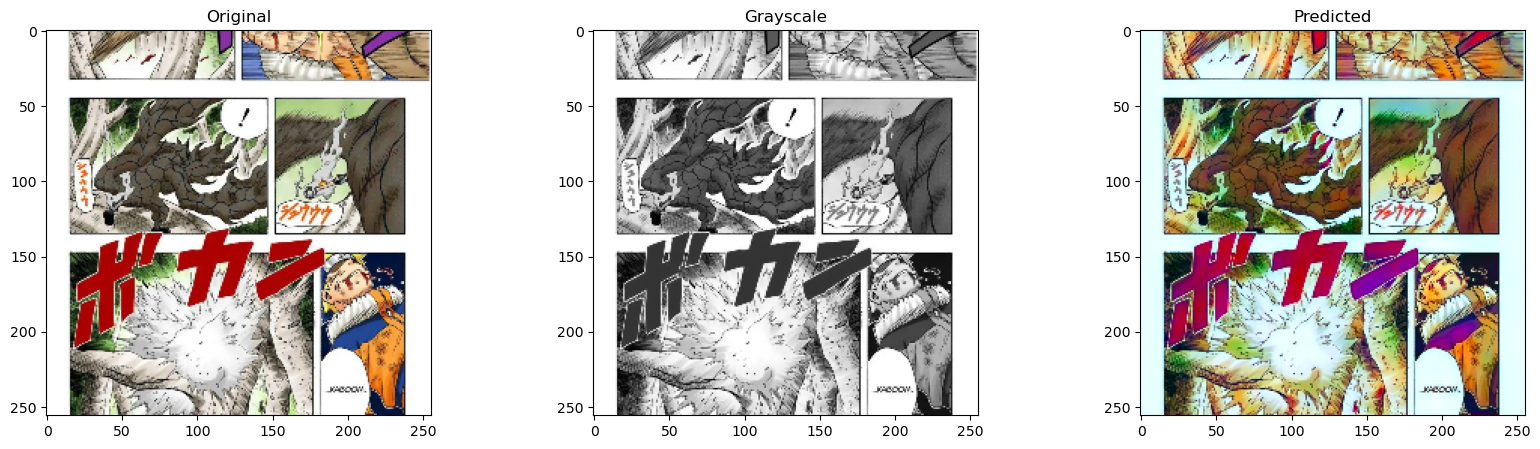

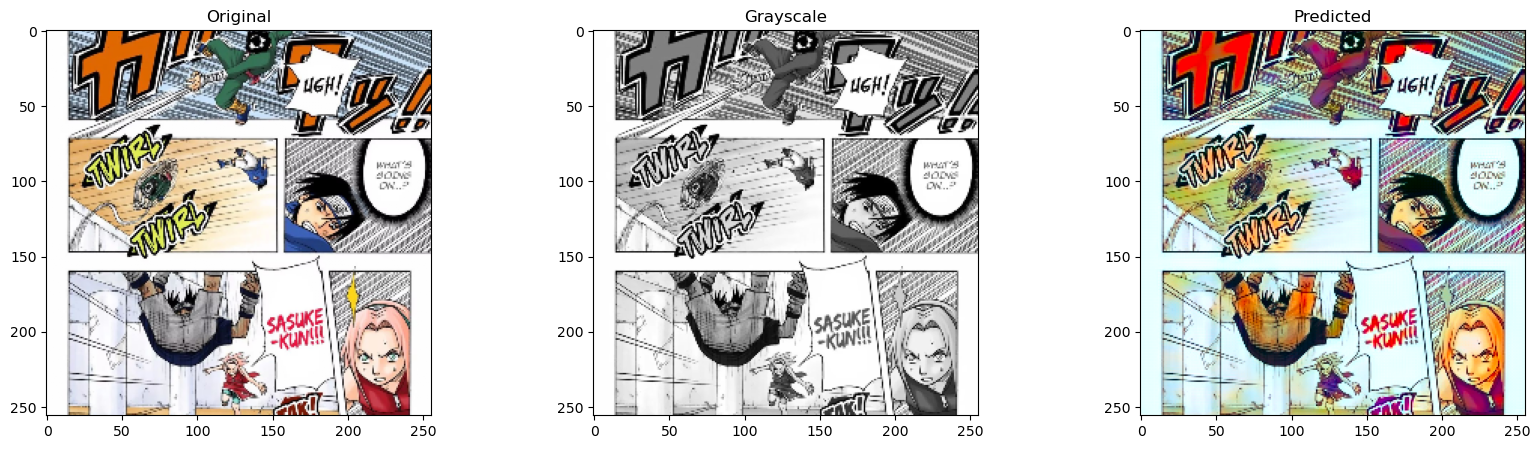

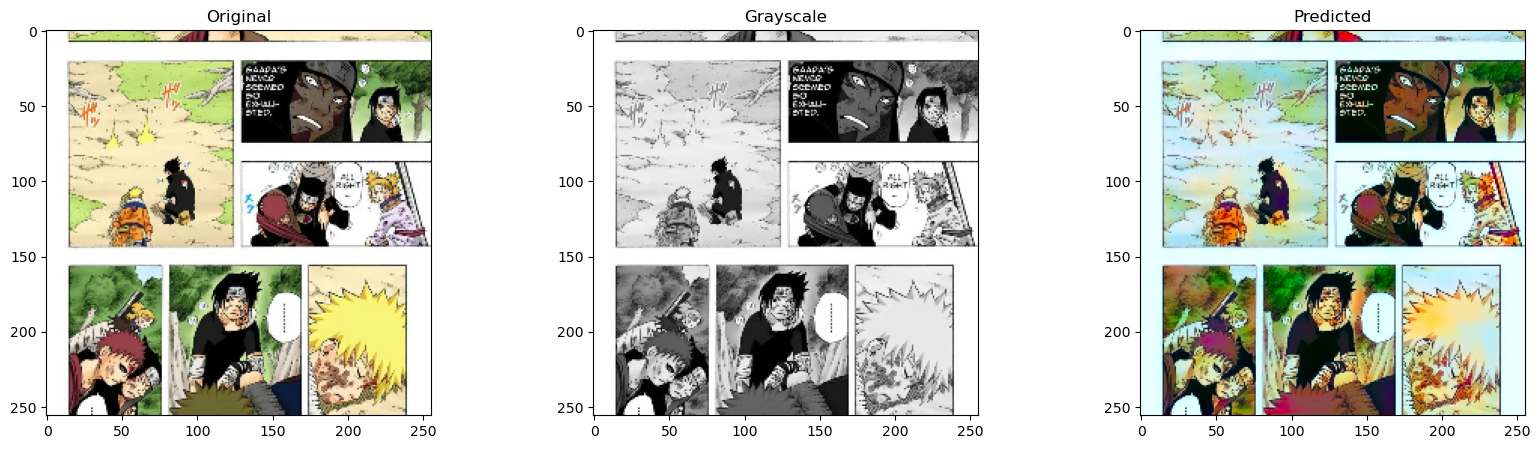

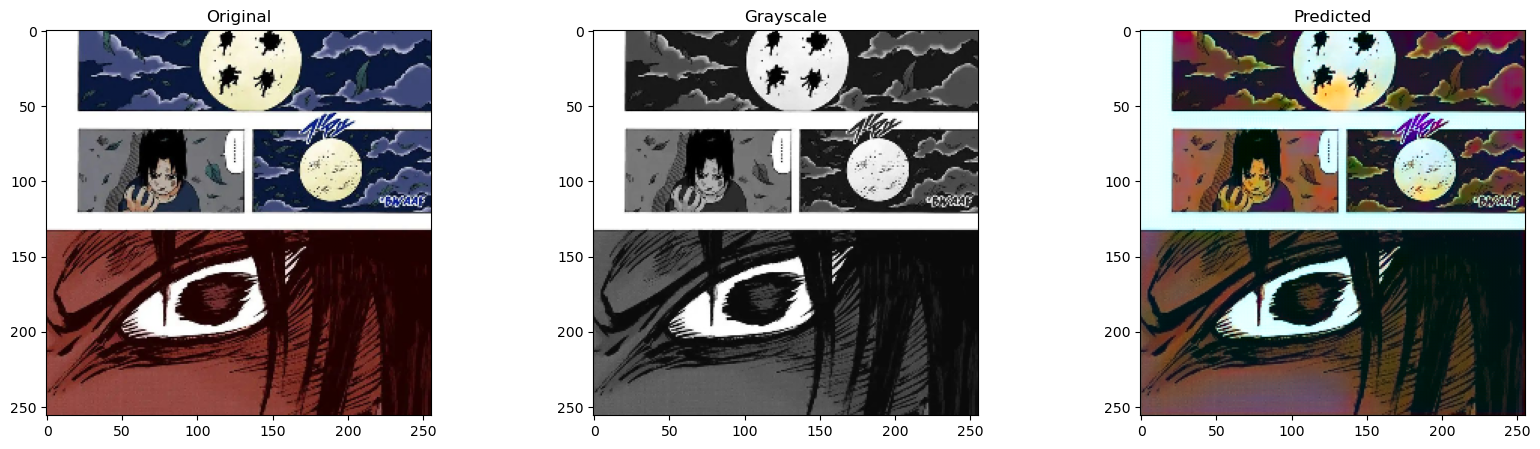

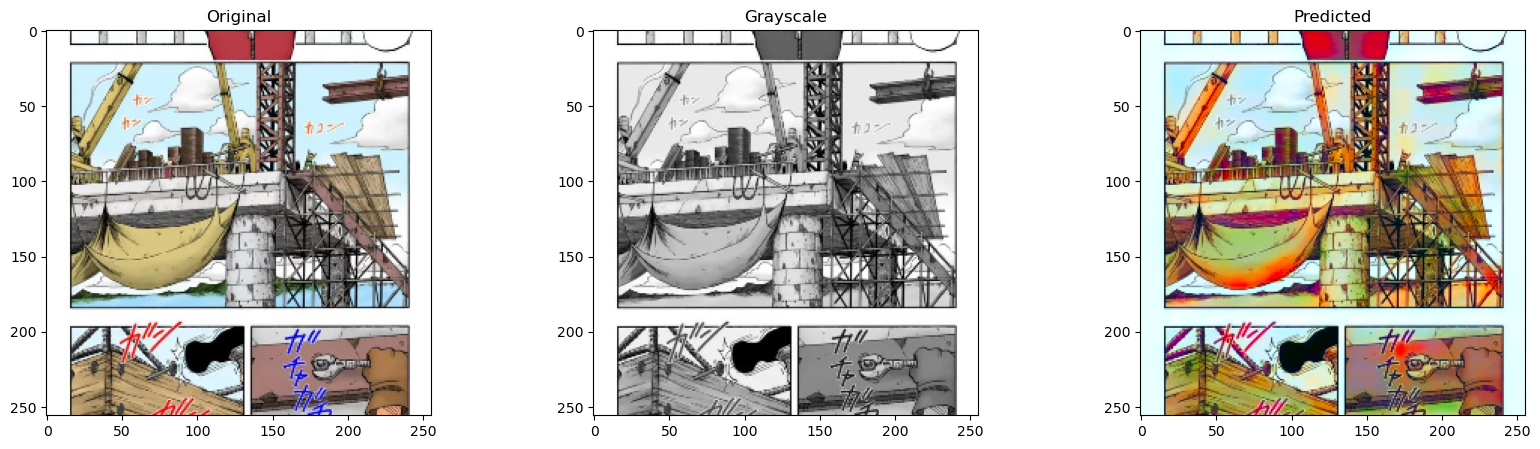

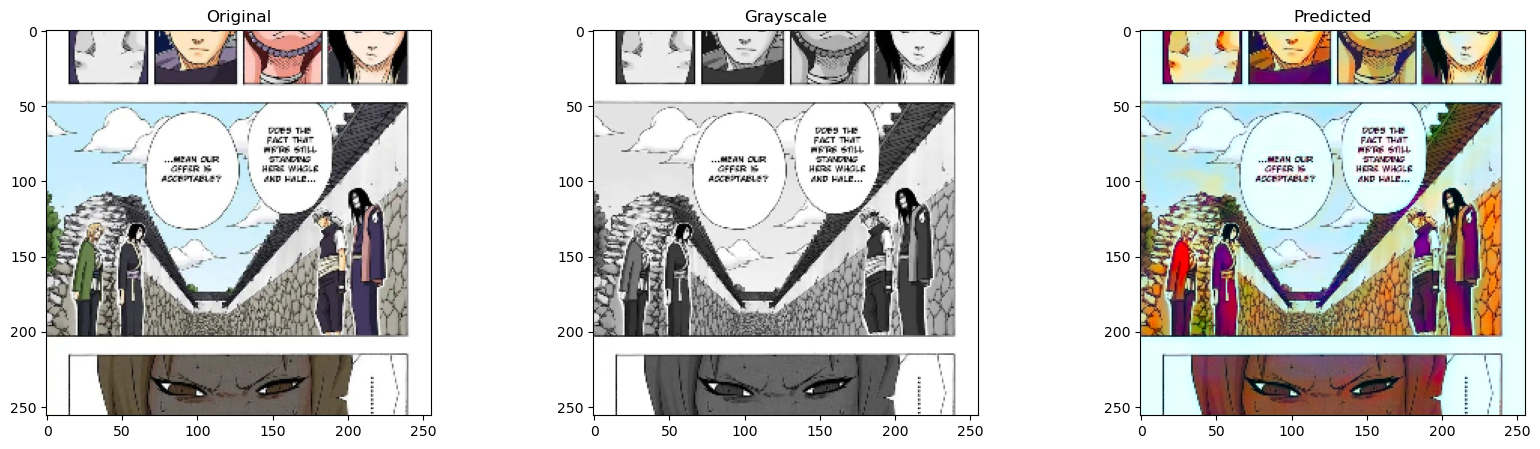

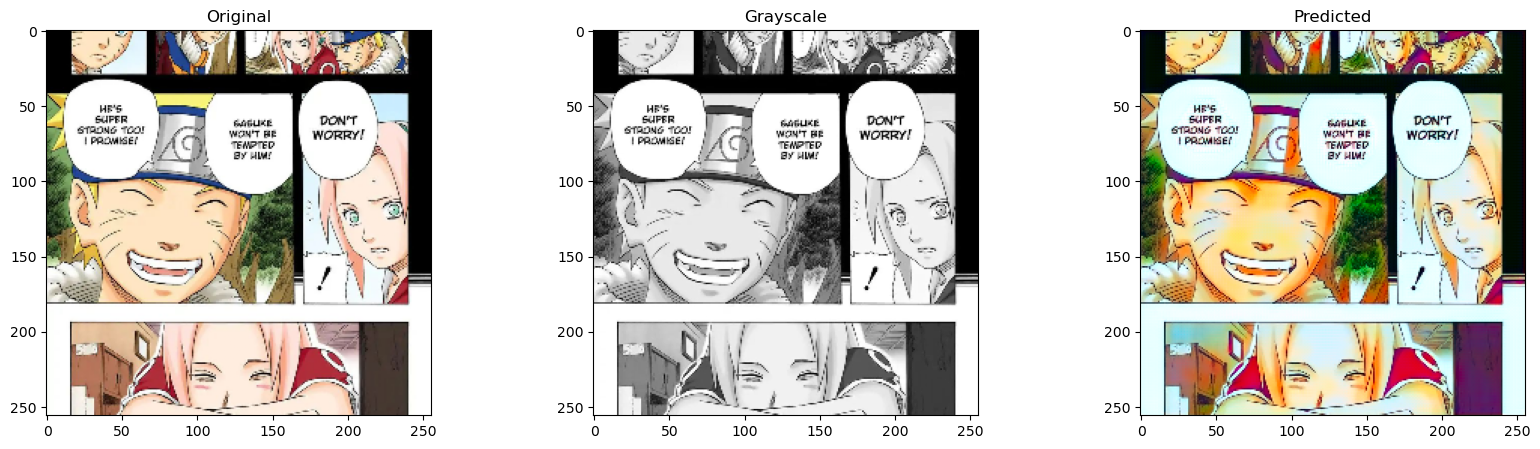

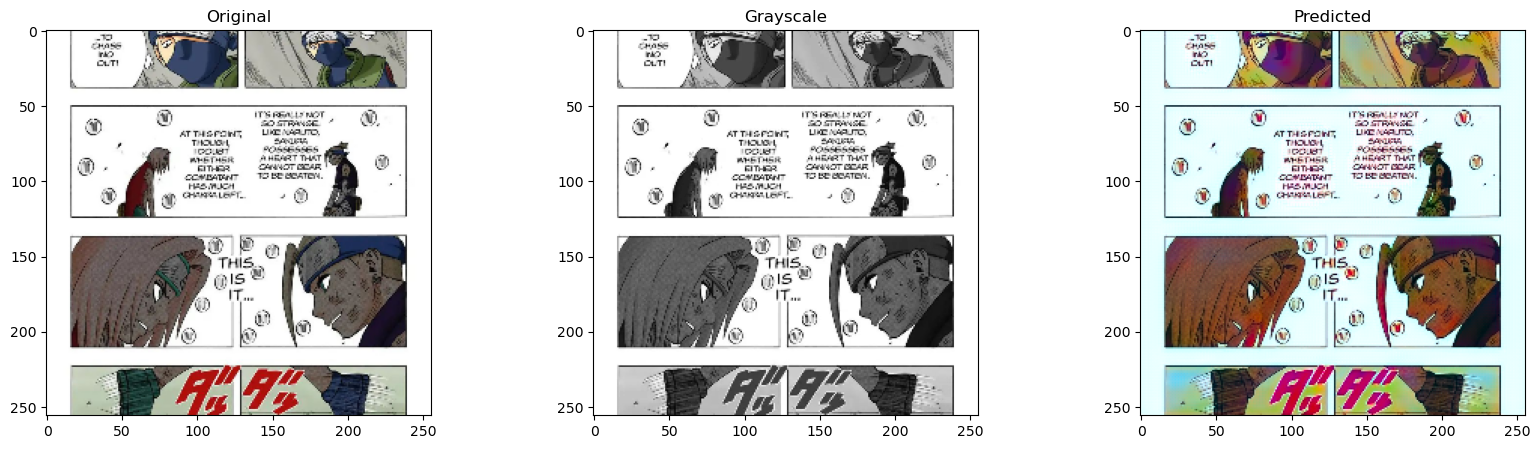

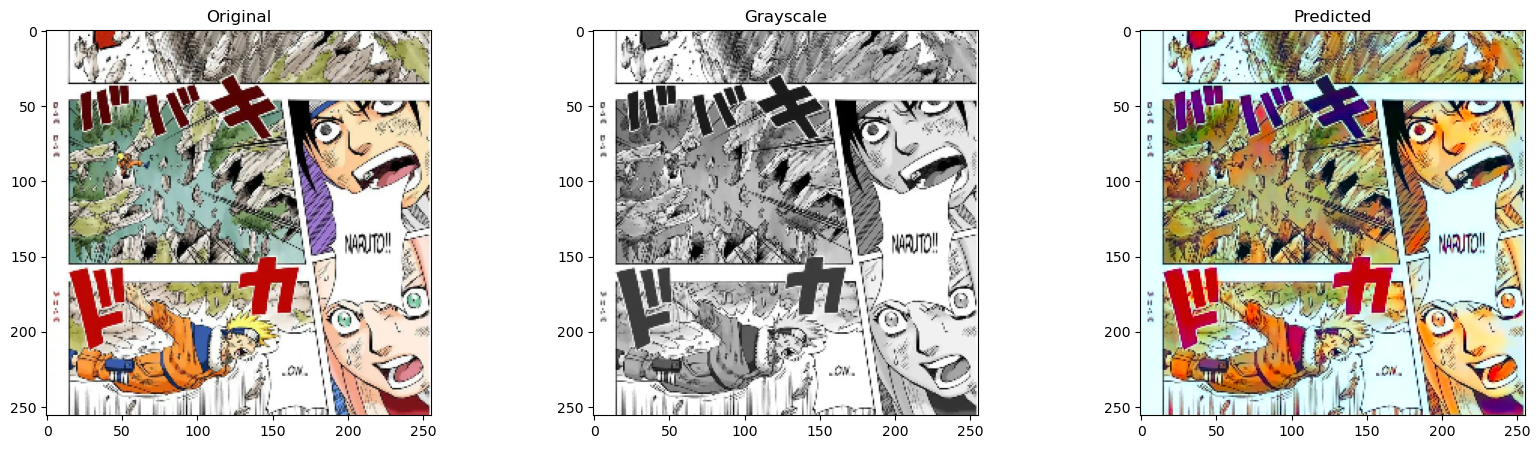

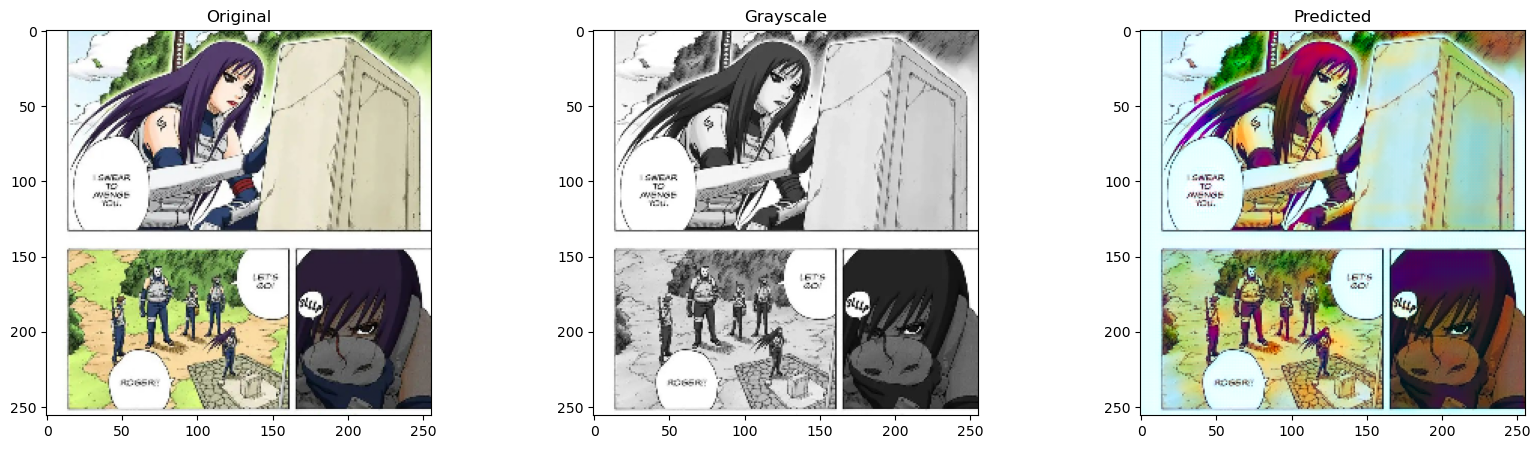

In [15]:

for i in range(10):
    display_results(x_test_color[i], x_test_gray[i], predicted_rgb[i])